## LightGBM multi-output baseline 
- 70/15/15 split
- metrics (R2, RMSE, MAE)
- R² bars (Validation vs Test: pink vs light-blue)
- Scatter grid (TEST ONLY, darkblue + red dashed 45°)
- Residual histograms (TEST ONLY, light-blue + dashed zero line)
- Mean LGBM importance averaged across outputs (light-blue)

[INFO] Using 107919 rows
[INFO] Train time: 12.029s

=== Train Set ===
                  Target     R2       RMSE        MAE
voltage_rise_time_pulse1 0.9780 5.9701e-10 3.4977e-10
voltage_rise_time_pulse2 0.9220 1.2360e-09 6.9167e-10
voltage_fall_time_pulse1 0.9997 1.1688e-10 7.4704e-11
voltage_fall_time_pulse2 0.9997 1.1437e-10 7.3802e-11
current_rise_time_pulse1 0.9315 1.2350e-08 6.3663e-09
current_rise_time_pulse2 0.9144 7.7750e-09 4.2933e-09
current_fall_time_pulse1 0.9996 2.5662e-10 1.4587e-10
current_fall_time_pulse2 0.9996 2.3999e-10 1.5013e-10
       overshoot_pulse_1 0.9785 1.9756e+00 1.5333e+00
       overshoot_pulse_2 0.9453 6.2417e+00 4.8358e+00
      undershoot_pulse_1 0.9864 1.5822e+00 1.0198e+00
      undershoot_pulse_2 0.9874 1.5255e+00 1.0017e+00
   ringing_frequency_MHz 0.9991 9.8059e-01 7.1142e-01
R2_avg          0.9724
RMSE_avg    1.9346e+00
MAE_avg     7.0016e-01
dtype: object
Predict Time (ms/sample): 0.0278

=== Validation Set ===
                  Target     R2  

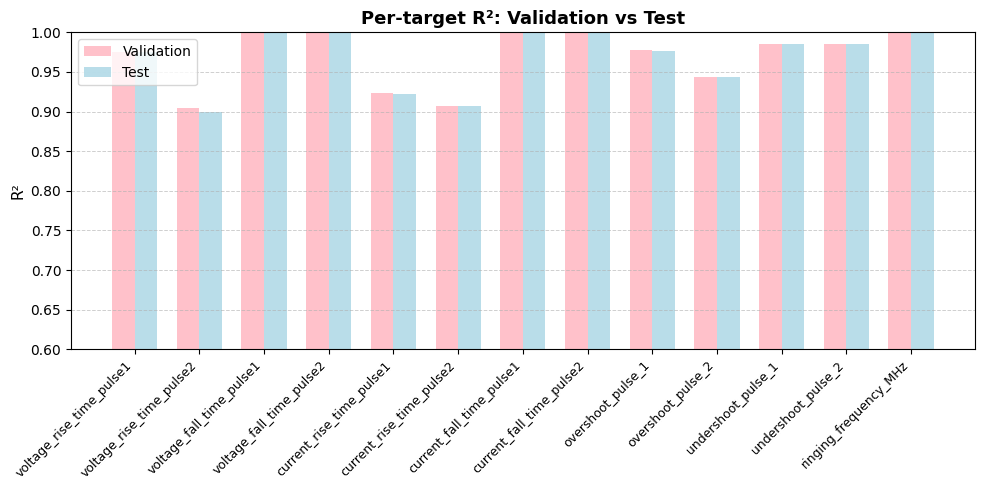

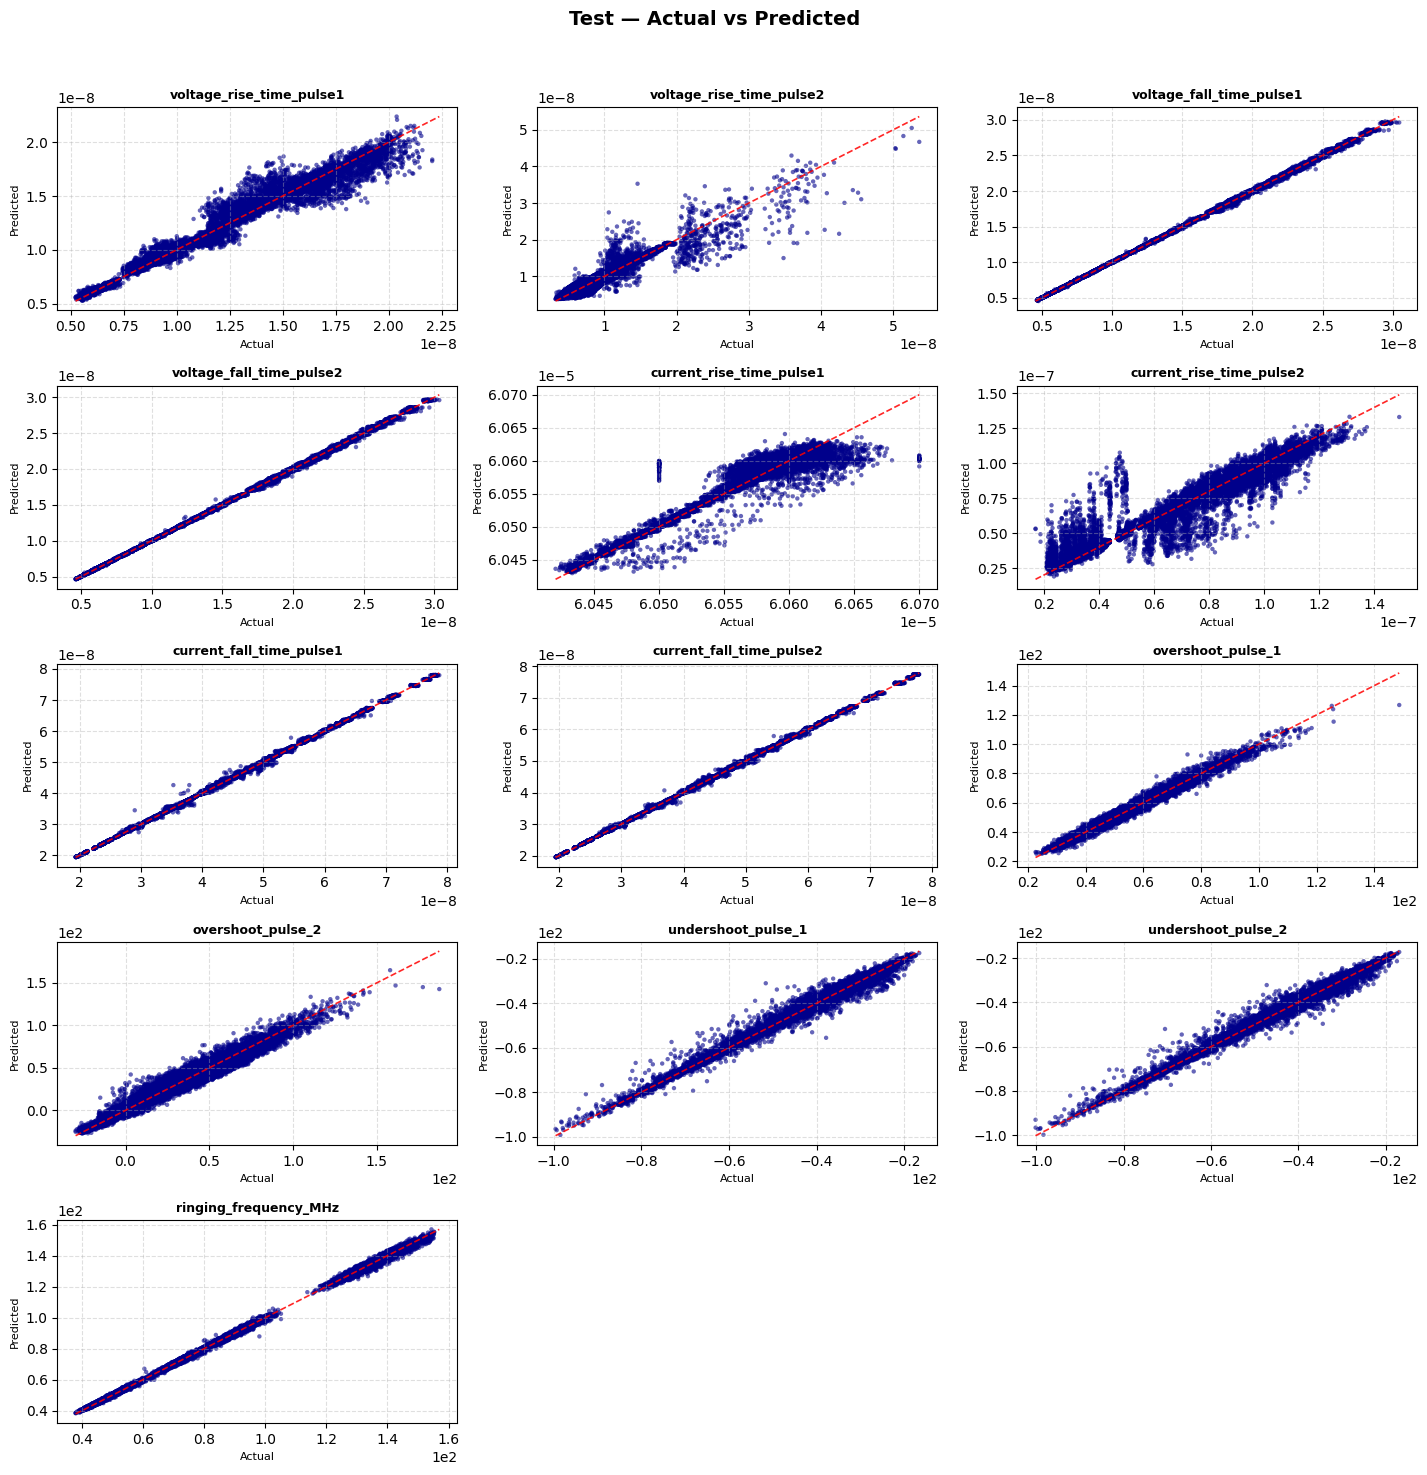

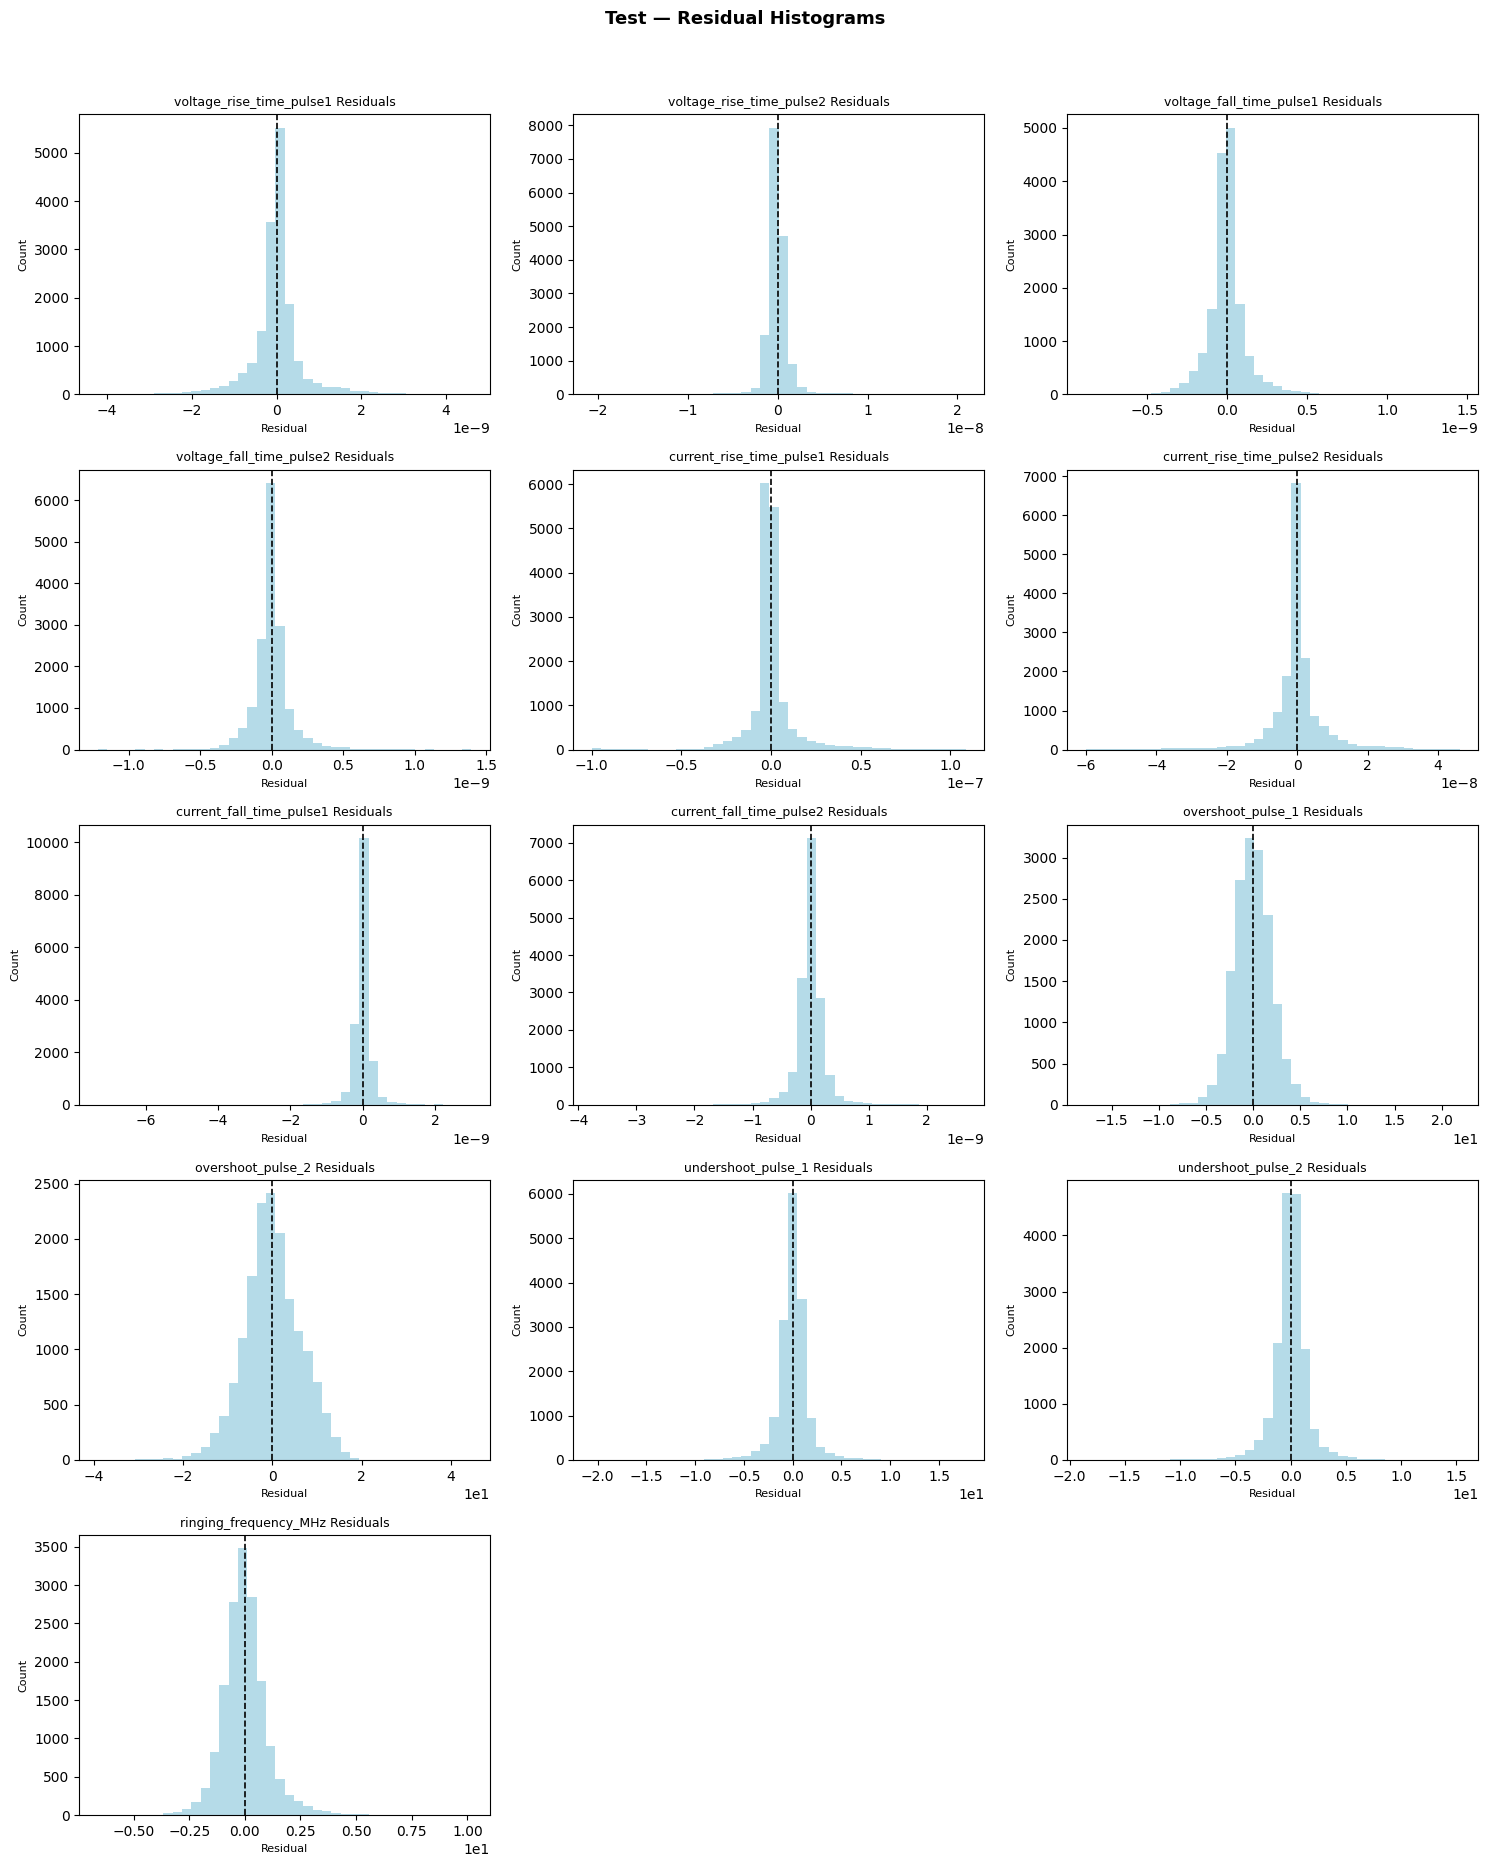

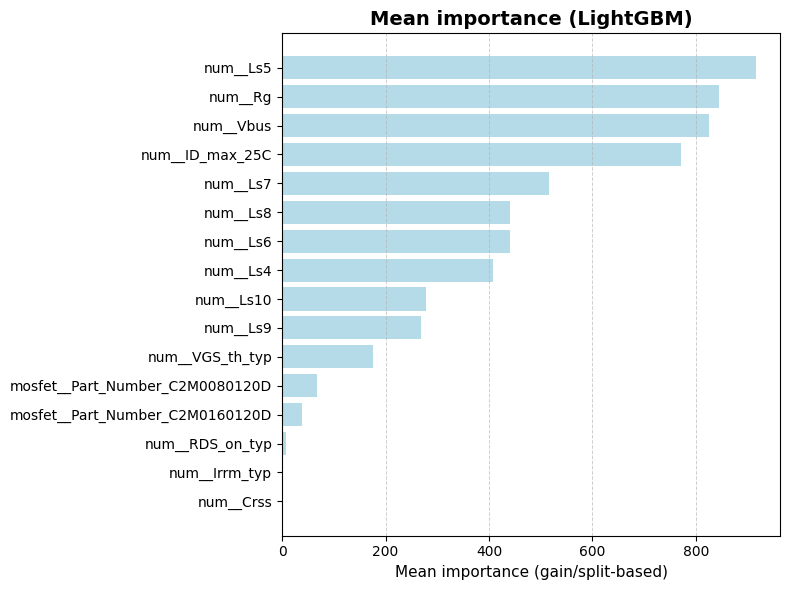

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor

from lightgbm import LGBMRegressor

DATA_FILE  = r"C:\Users\pc\Desktop\THESIS_DISTINCTION_THRISHA_RAJKUMAR\merged_train_5_MOSFETs.csv"

FAST_MODE  = True   # turn off for full dataset runs
FAST_SEED  = 42
FAST_FRAC  = 0.25   # take 25% uniformly at random

GRID_COLS      = 3  # columns in grid-style plots
TOP_K_IMPORT   = 16 # top-N features in importance plot
# ====================================================

# 13 switching-transient targets (multi-output)
TARGETS = [
    'voltage_rise_time_pulse1','voltage_rise_time_pulse2',
    'voltage_fall_time_pulse1','voltage_fall_time_pulse2',
    'current_rise_time_pulse1','current_rise_time_pulse2',
    'current_fall_time_pulse1','current_fall_time_pulse2',
    'overshoot_pulse_1','overshoot_pulse_2',
    'undershoot_pulse_1','undershoot_pulse_2',
    'ringing_frequency_MHz'
]

# Categorical column (device identity); we one-hot it in the pipeline
CAT_COLS = ['Part_Number']


# ------------------------------------------------------------
# 1) Load and basic setup
# ------------------------------------------------------------
# Read, enforce presence of all targets, drop rows missing any target
df = pd.read_csv(DATA_FILE).dropna(subset=TARGETS).reset_index(drop=True)

# Optional dev-mode subsampling to iterate faster
if FAST_MODE:
    df = df.sample(frac=FAST_FRAC, random_state=FAST_SEED).reset_index(drop=True)
print(f"[INFO] Using {len(df)} rows")

# Split features/targets
X = df.drop(columns=TARGETS)
y = df[TARGETS].values  # shape: (n_samples, 13)

# Identify numeric columns (everything except CAT_COLS)
num_cols = [c for c in X.columns if c not in CAT_COLS]


# ------------------------------------------------------------
# 2) Preprocessing pipeline
# ------------------------------------------------------------
def make_ohe():
    """
    Return a OneHotEncoder that works for sklearn>=1.4 and older.
    LightGBM can handle categoricals directly too, but here we use OHE
    to stay consistent with other baselines and to keep feature names explicit.
    """
    try:
        return OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    except TypeError:  # older sklearn
        return OneHotEncoder(handle_unknown='ignore', sparse=False)

# NOTE:
# - Trees/boosting do not require scaling, but standardizing numeric features
#   is harmless and keeps preprocessing consistent across models.
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("mosfet", make_ohe(), CAT_COLS),
    ],
    remainder="drop"
)

# In sklearn>=1.2, this makes the transformer return a pandas DataFrame
# so LightGBM "sees" feature names at fit *and* predict time (avoids warnings).
try:
    pre.set_output(transform="pandas")
except AttributeError:
    pass


# ------------------------------------------------------------
# 3) Model definition
# ------------------------------------------------------------
# Quiet LightGBM logs and use a sensible baseline config.
# (Force row-wise to silence LightGBM's internal choice messages.)
lgb_params = {
    "n_estimators": 200,
    "learning_rate": 0.10,
    "max_depth": -1,       # -1 = no max depth (leaf-wise growth)
    "n_jobs": -1,          # use all CPU cores
    "random_state": FAST_SEED,
    "verbosity": -1,       # silence LightGBM info logs
    "force_row_wise": True # avoid "column-wise vs row-wise" hints
}

# MultiOutputRegressor fits one LGBMRegressor per target (13 total)
# and ensures the same preprocessing is applied within the pipeline.
model = Pipeline([
    ("preprocessor", pre),
    ("regressor", MultiOutputRegressor(LGBMRegressor(**lgb_params)))
])

# Final safeguard to mute a known sklearn-user warning about feature names
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but LGBMRegressor was fitted with feature names"
)


# ------------------------------------------------------------
# 4) Train / validation / test split and training
# ------------------------------------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=FAST_SEED, shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=FAST_SEED, shuffle=True
)

t0 = time.time()
model.fit(X_train, y_train)
print(f"[INFO] Train time: {time.time() - t0:.3f}s")


# ------------------------------------------------------------
# 5) Evaluation helpers
# ------------------------------------------------------------
def eval_block(name: str, Xs, ys):
    """
    Predict on a split, compute per-target and overall metrics,
    and print a tidy summary.
    """
    t0 = time.time()
    y_pred = model.predict(Xs)
    ms_per_sample = (time.time() - t0) / max(1, len(Xs)) * 1000.0

    # Per-target metrics
    rows = []
    for i, t in enumerate(TARGETS):
        yt, yp = ys[:, i], y_pred[:, i]
        rows.append([
            t,
            r2_score(yt, yp),
            np.sqrt(mean_squared_error(yt, yp)),
            mean_absolute_error(yt, yp),
        ])
    dfm = pd.DataFrame(rows, columns=["Target", "R2", "RMSE", "MAE"])

    # Overall (averaged) metrics across outputs
    overall = {
        "R2_avg":   r2_score(ys, y_pred, multioutput="uniform_average"),
        "RMSE_avg": np.sqrt(mean_squared_error(ys, y_pred)),
        "MAE_avg":  mean_absolute_error(ys, y_pred),
    }

    # Pretty print for the console
    dfp = dfm.copy()
    dfp["R2"]   = dfp["R2"].map(lambda x: f"{x:.4f}")
    dfp["RMSE"] = dfp["RMSE"].map(lambda x: f"{x:.4e}")
    dfp["MAE"]  = dfp["MAE"].map(lambda x: f"{x:.4e}")
    over = {
        "R2_avg":   f"{overall['R2_avg']:.4f}",
        "RMSE_avg": f"{overall['RMSE_avg']:.4e}",
        "MAE_avg":  f"{overall['MAE_avg']:.4e}",
    }

    print(f"\n=== {name} ===")
    print(dfp.to_string(index=False))
    print(pd.Series(over))
    print(f"Predict Time (ms/sample): {ms_per_sample:.4f}")

    return y_pred, dfm, overall


# ------------------------------------------------------------
# 6) Plotting helpers
# ------------------------------------------------------------
def plot_r2_bars(val_df: pd.DataFrame, test_df: pd.DataFrame):
    """
    Validation vs Test R² (pink vs light-blue).
    Quickly surfaces targets with potential generalization gaps.
    """
    targets = val_df["Target"].tolist()
    x = np.arange(len(targets))
    width = 0.35

    fig, ax = plt.subplots(figsize=(max(10, 0.6 * len(targets)), 5))
    ax.bar(x - width/2, val_df["R2"].values,  width,
           label="Validation", color="#ffb6c1", alpha=0.85)
    ax.bar(x + width/2, test_df["R2"].values, width,
           label="Test", color="#add8e6", alpha=0.85)

    ax.set_xticks(x)
    ax.set_xticklabels(targets, rotation=45, ha="right", fontsize=9)
    ax.set_ylabel("R²", fontsize=11)
    ax.set_title("Per-target R²: Validation vs Test", fontsize=13, weight="bold")
    ax.set_ylim(0.6, 1.0)
    ax.grid(axis='y', linestyle='--', alpha=0.6, linewidth=0.7)
    ax.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

def plot_scatter_grid_test_only(y_true: np.ndarray, y_pred: np.ndarray, n_cols=GRID_COLS):
    """
    TEST ONLY — Actual vs Predicted scatter.
    Blue points with a red dashed y=x ideal reference line.
    """
    n_targets = len(TARGETS)
    n_rows = int(np.ceil(n_targets / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.8 * n_cols, 3.0 * n_rows))
    axes = axes.flatten()

    for i, t in enumerate(TARGETS):
        ax = axes[i]
        ax.scatter(y_true[:, i], y_pred[:, i], s=10, alpha=0.6,
                   color="darkblue", edgecolors="none")
        mn = min(y_true[:, i].min(), y_pred[:, i].min())
        mx = max(y_true[:, i].max(), y_pred[:, i].max())
        ax.plot([mn, mx], [mn, mx], '--', lw=1.2, color="red", alpha=0.85)
        ax.set_title(t, fontsize=9, weight="bold")
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
        ax.set_xlabel("Actual", fontsize=8)
        ax.set_ylabel("Predicted", fontsize=8)

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle("Test — Actual vs Predicted", fontsize=14, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_residual_histograms_test_only(y_true: np.ndarray, y_pred: np.ndarray, n_cols=GRID_COLS):
    """
    TEST ONLY — Residual distribution per target.
    Symmetric, zero-centered histograms indicate unbiased errors.
    """
    residuals = y_true - y_pred
    n_targets = len(TARGETS)
    n_rows = int(np.ceil(n_targets / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3.8 * n_rows))
    axes = axes.flatten()

    for i, t in enumerate(TARGETS):
        ax = axes[i]
        ax.hist(residuals[:, i], bins=40, color="#add8e6", alpha=0.9)
        ax.axvline(0, color='black', linestyle='--', linewidth=1.2)
        ax.set_title(f"{t} Residuals", fontsize=9)
        ax.set_xlabel("Residual", fontsize=8)
        ax.set_ylabel("Count", fontsize=8)
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
        ax.grid(False)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle("Test — Residual Histograms", fontsize=13, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def get_feature_names_from_preprocessor(preprocessor, num_names, cat_names):
    """
    Retrieve transformed feature names from the ColumnTransformer,
    including expanded one-hot category levels.
    """
    try:
        return preprocessor.get_feature_names_out()
    except Exception:
        names = [f"num__{n}" for n in num_names]
        try:
            ohe = preprocessor.named_transformers_["mosfet"]
            cats = ohe.categories_
            for col, levels in zip(cat_names, cats):
                names += [f"mosfet__{col}={lvl}" for lvl in levels]
        except Exception:
            names += [f"mosfet__{c}_<onehot>" for c in cat_names]
        return np.array(names, dtype=object)

def plot_mean_importance_lgbm(pipeline: Pipeline,
                              num_names,
                              cat_names,
                              top_k: int = TOP_K_IMPORT):
    """
    Compute mean LightGBM feature importance across the 13 outputs.
    (Each target has its own LGBMRegressor; we average importances.)
    """
    pre = pipeline.named_steps["preprocessor"]
    reg = pipeline.named_steps["regressor"]  # MultiOutputRegressor
    feat_names = get_feature_names_from_preprocessor(pre, num_names, cat_names)

    # Collect per-target importances (shape: n_targets x n_features)
    importances = [est.feature_importances_ for est in reg.estimators_]
    importances = np.array(importances)
    mean_imp = importances.mean(axis=0)

    imp_df = (pd.DataFrame({"feature": feat_names, "importance": mean_imp})
              .sort_values("importance", ascending=False)
              .head(top_k)
              .iloc[::-1])

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(imp_df["feature"], imp_df["importance"], color="#add8e6", alpha=0.9)
    ax.set_title("Mean importance (LightGBM)", fontsize=14, weight="bold")
    ax.set_xlabel("Mean importance (gain/split-based)", fontsize=11)
    ax.set_ylabel("")
    ax.grid(axis="x", linestyle="--", alpha=0.6, linewidth=0.7)
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# 7) Run evaluations + plots
# ------------------------------------------------------------
y_tr_pred, tr_df, _ = eval_block("Train Set", X_train, y_train)
y_va_pred, va_df, _ = eval_block("Validation Set", X_val,  y_val)
y_te_pred, te_df, _ = eval_block("Test Set",       X_test, y_test)

# High-level diagnostic visuals
plot_r2_bars(va_df, te_df)                                # Val vs Test R² bars
plot_scatter_grid_test_only(y_test, y_te_pred)            # Test: Actual vs Predicted
plot_residual_histograms_test_only(y_test, y_te_pred)     # Test: Residual histograms
plot_mean_importance_lgbm(model, num_cols, CAT_COLS)      # Mean feature importance
